In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio.v2 as imageio
import os
import shutil

# Visual settings
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 10,
    'figure.dpi': 120,
    'axes.grid': True
})

sns.set_theme(style="dark")
plt.style.use('dark_background')

class RadiotherapyModel:
    def __init__(self, L=10, N=80, dt=0.01):
        self.L = L
        self.N = N
        self.dx = L / N
        self.dt = dt
        self.x = np.linspace(-L/2, L/2, N)
        self.y = np.linspace(-L/2, L/2, N)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        
        r = np.sqrt(self.X**2 + self.Y**2)
        self.H = 0.2 + 0.8 * (1 / (1 + np.exp(-(r - 2.0)*3)))

    def get_initial_tumor(self):
        r = np.sqrt(self.X**2 + self.Y**2)
        return 0.9 * np.exp(-(r**2)/2.0)

    def get_laplacian(self, u):
        u_top = np.roll(u, 1, axis=0)
        u_bottom = np.roll(u, -1, axis=0)
        u_left = np.roll(u, 1, axis=1)
        u_right = np.roll(u, -1, axis=1)
        return (u_top + u_bottom + u_left + u_right - 4*u) / (self.dx**2)

    def get_radiation_spatial_map(self, mode='centered'):
        """Creates the spatial footprint of the radiation beam."""
        if mode == 'centered':
            # Perfect alignment with tumor center
            r_sq = self.X**2 + self.Y**2
            return np.exp(-r_sq / 4.0)
        elif mode == 'offset':
            # Hits only the right side (x > 1.5)
            # Gaussian shifted by x=2.5
            r_sq_shift = (self.X - 2.5)**2 + self.Y**2
            return np.exp(-r_sq_shift / 4.0)
        return np.zeros_like(self.X)

    def run_simulation(self, 
                       experiment_name,
                       total_time=25, 
                       dose_interval=5.0, 
                       beam_mode='centered',
                       hypoxia_enabled=True,
                       D=0.05, rho=0.1, beta=10.0):
        
        u = self.get_initial_tumor()
        steps = int(total_time / self.dt)
        spatial_R = self.get_radiation_spatial_map(beam_mode)
        
        # Handling Hypoxia Toggle: if disabled, H is effectively 1 everywhere
        H_map = self.H if hypoxia_enabled else np.ones_like(self.H)

        # Metrics storage
        time_history = []
        mass_history = []
        
        # Directory setup
        output_dir = f"frames_{experiment_name}"
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
        os.makedirs(output_dir)

        # --- PLOTTING SETUP ---
        # We create the figure once and clear/redraw efficiently
        # However, for saving frames, creating new figures is often safer/easier
        # to avoid artifact accumulation in loops.
        
        print(f"Starting Experiment: {experiment_name}")
        
        dose_duration = 0.5 # How long the beam stays ON per interval
        
        for n in range(steps):
            t = n * self.dt
            
            # --- 1. Determine Radiation T(t) ---
            # Fractionated dosing: ON if within [k*interval, k*interval + duration]
            cycle_t = t % dose_interval
            radiation_on = 1.0 if cycle_t < dose_duration else 0.0
            
            # --- 2. PDE SOLVER ---
            lap = self.get_laplacian(u)
            growth = rho * u * (1 - u) # Logistic growth (K=1)
            
            # Kill term: beta * R(x,y) * T(t) * H(x,y) * u
            kill = - beta * spatial_R * radiation_on * H_map * u
            
            u = u + (D * lap + growth + kill) * self.dt
            u = np.clip(u, 0, 1) # Bounds
            
            # Data collection
            current_mass = np.sum(u) * (self.dx**2)
            time_history.append(t)
            mass_history.append(current_mass)

            # --- 3. VISUALIZATION (Every 25th frame) ---
            if n % 25 == 0:
                fig = plt.figure(figsize=(12, 5))
                gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.2])

                # Left Plot: Spatial Heatmap
                ax1 = fig.add_subplot(gs[0])
                im = ax1.pcolormesh(self.X, self.Y, u, cmap='magma', vmin=0, vmax=1, shading='auto')
                
                # Overlay Beam location (Yellow dashed)
                if radiation_on > 0:
                    ax1.contour(self.X, self.Y, spatial_R, levels=[0.5], colors='yellow', linewidths=2)
                    ax1.text(-4.5, 4.5, "BEAM ON", color='yellow', fontweight='bold', backgroundcolor='black')
                
                # Overlay Hypoxia (Cyan dashed)
                if hypoxia_enabled:
                    ax1.contour(self.X, self.Y, H_map, levels=[0.5], colors='cyan', linestyles='--')
                
                ax1.set_title(f"Tumor Density map (t={t:.1f})")
                ax1.set_aspect('equal')

                # Right Plot: Dynamic Mass
                ax2 = fig.add_subplot(gs[1])
                ax2.plot(time_history, mass_history, color='red', linewidth=2)
                ax2.set_xlim(0, total_time)
                ax2.set_ylim(0, max(mass_history)*1.1)
                ax2.set_xlabel("Time")
                ax2.set_ylabel("Total Tumor Mass")
                ax2.set_title("Response to Therapy")
                
                # Mark Dose times on the timeline
                dose_times = np.arange(0, total_time, dose_interval)
                for dt_start in dose_times:
                    if t >= dt_start:
                        ax2.axvspan(dt_start, min(t, dt_start+dose_duration), color='yellow', alpha=0.3)
                
                plt.tight_layout()
                plt.savefig(f"{output_dir}/frame_{n:05d}.png")
                plt.close(fig)

        self.make_gif(output_dir, f"figures/{experiment_name}.gif")

    def make_gif(self, input_dir, filename):
        images = []
        files = sorted([f for f in os.listdir(input_dir) if f.endswith('.png')])
        for f in files:
            images.append(imageio.imread(os.path.join(input_dir, f)))
        imageio.mimsave(filename, images, fps=15, loop=0)
        print(f"Saved {filename}")

sim = RadiotherapyModel()
sim.run_simulation("standard", 
                   dose_interval=5.0, 
                   beam_mode='centered', 
                   hypoxia_enabled=True)

sim.run_simulation("offset_beam", 
                   dose_interval=5.0, 
                   beam_mode='offset', 
                   hypoxia_enabled=True)

Starting Experiment: standard
Saved figures/standard.gif
Starting Experiment: offset_beam
Saved figures/offset_beam.gif


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio.v2 as imageio
import os
import shutil

# Visual settings
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 10,
    'figure.dpi': 120,
    'axes.grid': True
})

sns.set_theme(style="dark")
plt.style.use('dark_background')

class RadiotherapyModel:
    def __init__(self, L=10, N=80, dt=0.01):
        self.L = L
        self.N = N
        self.dx = L / N
        self.dt = dt
        self.x = np.linspace(-L/2, L/2, N)
        self.y = np.linspace(-L/2, L/2, N)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        
        r = np.sqrt(self.X**2 + self.Y**2)
        self.H = 0.001 + 0.999 * (1 / (1 + np.exp(-(r - 0.8)*15)))

    def get_initial_tumor(self):
        r = np.sqrt(self.X**2 + self.Y**2)
        return 0.9 * np.exp(-(r**2)/2.0)

    def get_laplacian(self, u):
        u_top = np.roll(u, 1, axis=0)
        u_bottom = np.roll(u, -1, axis=0)
        u_left = np.roll(u, 1, axis=1)
        u_right = np.roll(u, -1, axis=1)
        return (u_top + u_bottom + u_left + u_right - 4*u) / (self.dx**2)

    def get_radiation_spatial_map(self, mode='centered'):
        """Creates the spatial footprint of the radiation beam."""
        if mode == 'centered':
            # MODIFIED: Bigger Radiation Ring (wider Gaussian)
            r_sq = self.X**2 + self.Y**2
            # denominator 8.0 makes it twice as wide as previous 4.0
            return np.exp(-r_sq / 8.0) 
        elif mode == 'offset':
            # Hits only the right side (x > 1.5)
            # Gaussian shifted by x=2.5
            r_sq_shift = (self.X - 2.5)**2 + self.Y**2
            return np.exp(-r_sq_shift / 4.0)
        return np.zeros_like(self.X)

    def run_simulation(self, 
                       experiment_name,
                       total_time=25, 
                       dose_interval=5.0, 
                       beam_mode='centered',
                       hypoxia_enabled=True,
                       D=0.05, rho=0.1, beta=10.0):
        
        u = self.get_initial_tumor()
        steps = int(total_time / self.dt)
        spatial_R = self.get_radiation_spatial_map(beam_mode)
        
        # Handling Hypoxia Toggle: if disabled, H is effectively 1 everywhere
        H_map = self.H if hypoxia_enabled else np.ones_like(self.H)

        # Metrics storage
        time_history = []
        mass_history = []
        
        # Directory setup
        output_dir = f"frames_{experiment_name}"
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
        os.makedirs(output_dir)

        # --- PLOTTING SETUP ---
        print(f"Starting Experiment: {experiment_name}")
        
        dose_duration = 0.5 # How long the beam stays ON per interval
        
        for n in range(steps):
            t = n * self.dt
            
            # --- 1. Determine Radiation T(t) ---
            # Fractionated dosing: ON if within [k*interval, k*interval + duration]
            cycle_t = t % dose_interval
            radiation_on = 1.0 if cycle_t < dose_duration else 0.0
            
            # --- 2. PDE SOLVER ---
            lap = self.get_laplacian(u)
            growth = rho * u * (1 - u) # Logistic growth (K=1)
            
            # Kill term: beta * R(x,y) * T(t) * H(x,y) * u
            kill = - beta * spatial_R * radiation_on * H_map * u
            
            u = u + (D * lap + growth + kill) * self.dt
            u = np.clip(u, 0, 1) # Bounds
            
            # Data collection
            current_mass = np.sum(u) * (self.dx**2)
            time_history.append(t)
            mass_history.append(current_mass)

            # --- 3. VISUALIZATION (Every 25th frame) ---
            if n % 25 == 0:
                fig = plt.figure(figsize=(12, 5))
                gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.2])

                # Left Plot: Spatial Heatmap
                ax1 = fig.add_subplot(gs[0])
                im = ax1.pcolormesh(self.X, self.Y, u, cmap='magma', vmin=0, vmax=1, shading='auto')
                
                # Overlay Beam location (Yellow dashed)
                if radiation_on > 0:
                    ax1.contour(self.X, self.Y, spatial_R, levels=[0.5], colors='yellow', linewidths=2)
                    ax1.text(-4.5, 4.5, "BEAM ON", color='yellow', fontweight='bold', backgroundcolor='black')
                
                # Overlay Hypoxia (Cyan dashed)
                if hypoxia_enabled:
                    ax1.contour(self.X, self.Y, H_map, levels=[0.5], colors='cyan', linestyles='--')
                
                ax1.set_title(f"Tumor Density map (t={t:.1f})")
                ax1.set_aspect('equal')

                # Right Plot: Dynamic Mass
                ax2 = fig.add_subplot(gs[1])
                ax2.plot(time_history, mass_history, color='red', linewidth=2)
                ax2.set_xlim(0, total_time)
                ax2.set_ylim(0, max(mass_history)*1.1)
                ax2.set_xlabel("Time")
                ax2.set_ylabel("Total Tumor Mass")
                ax2.set_title("Response to Therapy")
                
                # Mark Dose times on the timeline
                dose_times = np.arange(0, total_time, dose_interval)
                for dt_start in dose_times:
                    if t >= dt_start:
                        ax2.axvspan(dt_start, min(t, dt_start+dose_duration), color='yellow', alpha=0.3)
                
                plt.tight_layout()
                plt.savefig(f"{output_dir}/frame_{n:05d}.png")
                plt.close(fig)

        self.make_gif(output_dir, f"figures/{experiment_name}.gif")

    def make_gif(self, input_dir, filename):
        images = []
        files = sorted([f for f in os.listdir(input_dir) if f.endswith('.png')])
        for f in files:
            images.append(imageio.imread(os.path.join(input_dir, f)))
        imageio.mimsave(filename, images, fps=15, loop=0)
        print(f"Saved {filename}")

if not os.path.exists("figures"):
    os.makedirs("figures")

sim = RadiotherapyModel()
sim.run_simulation("strong_hypoxia_big_beam", 
                   dose_interval=5.0, 
                   beam_mode='centered', 
                   hypoxia_enabled=True)

Starting Experiment: strong_hypoxia_big_beam
Saved figures/strong_hypoxia_big_beam.gif


Running Row 1: Biology...
Running Row 2: Timing...
Running Row 3: Dose Intensity vs Interval...


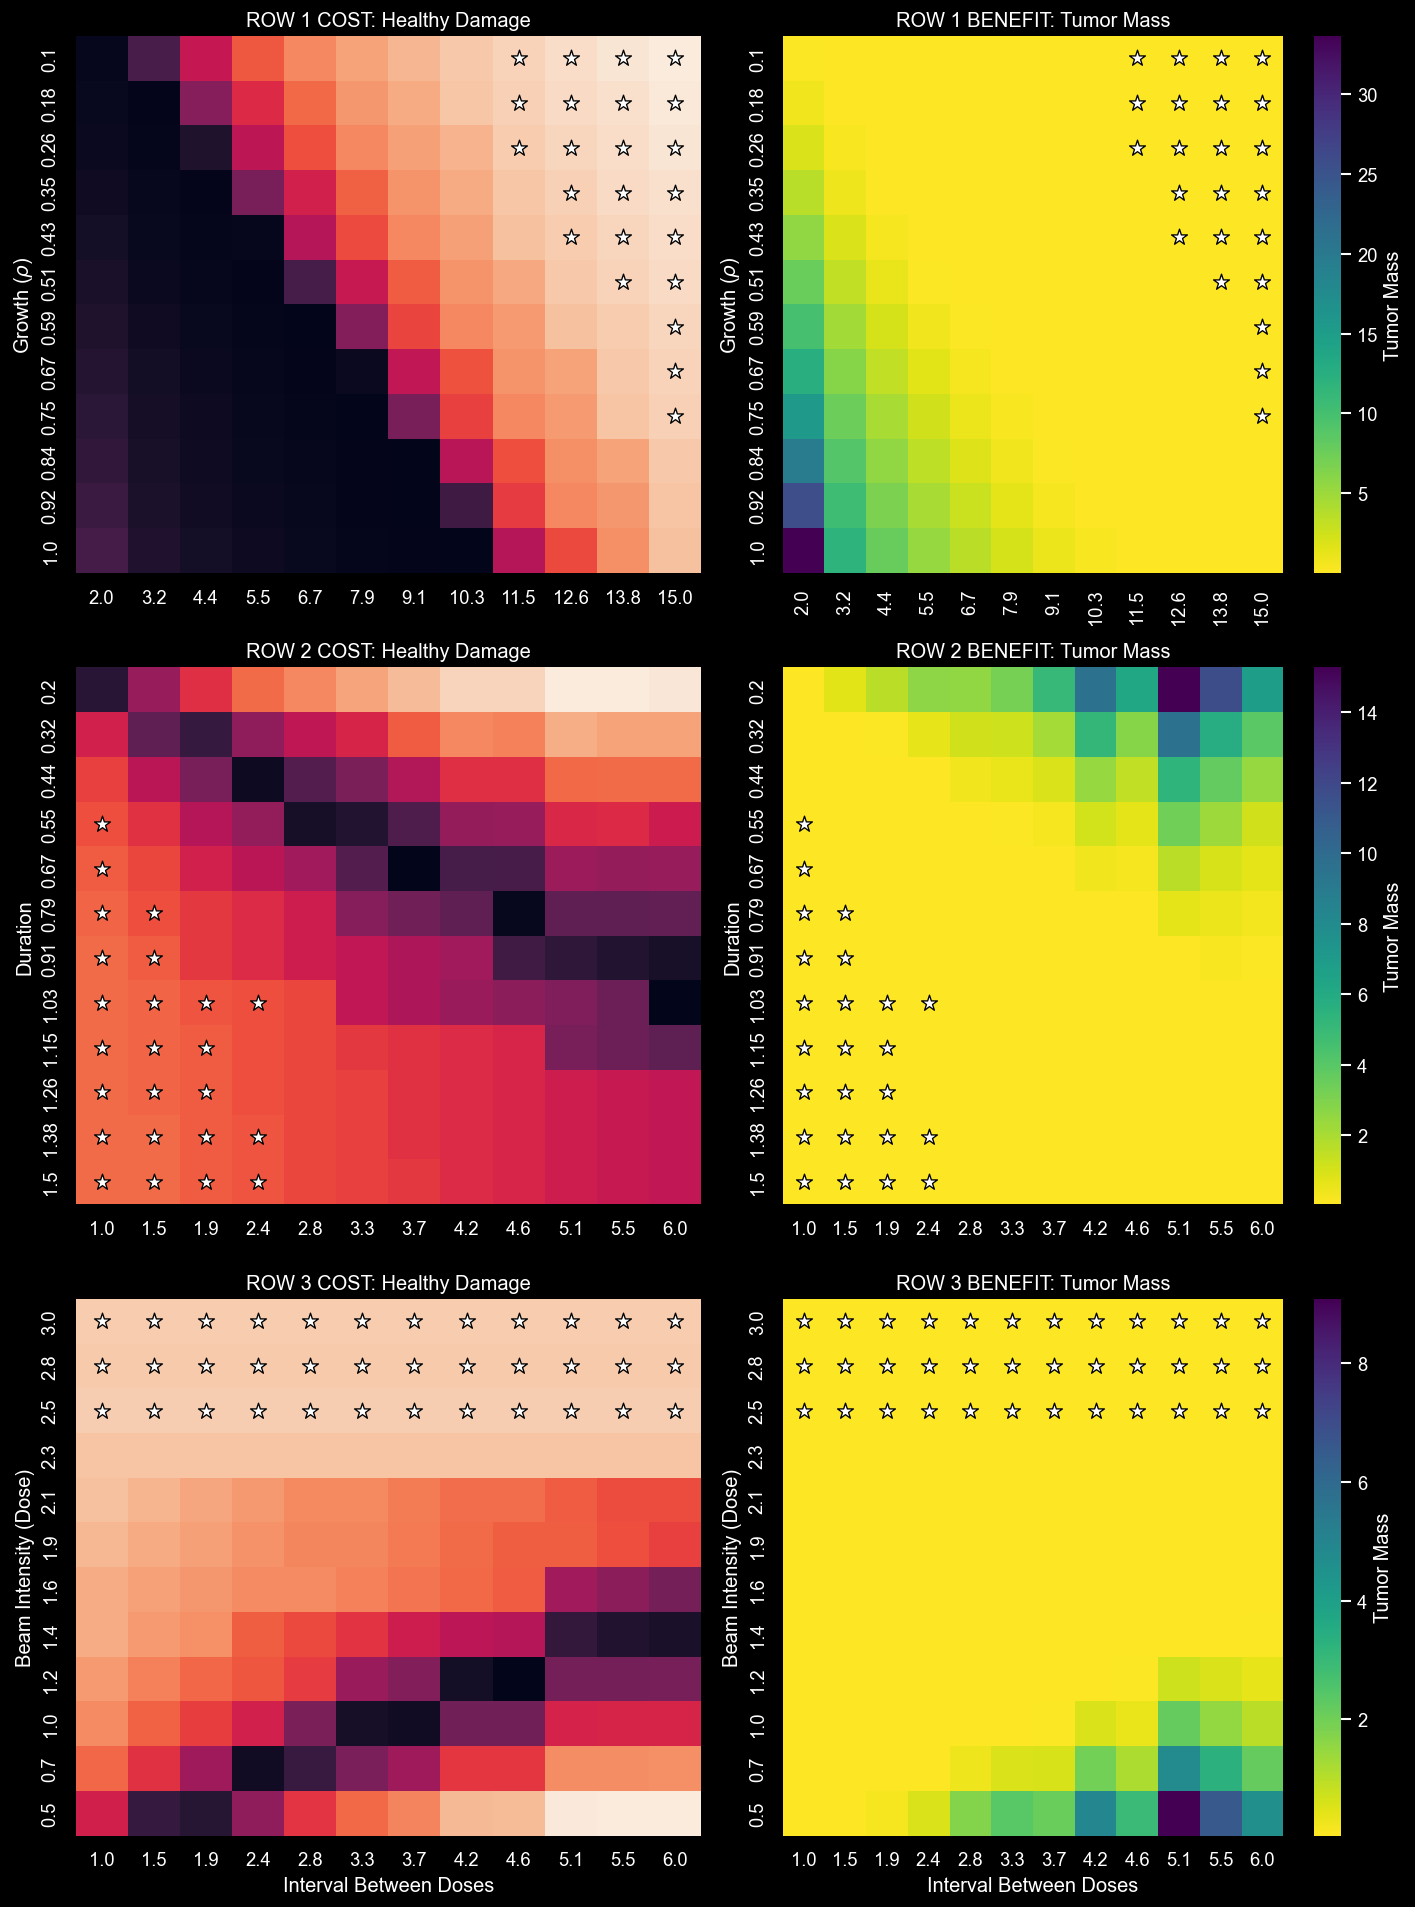

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set_theme(style="dark")
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 10, 'figure.dpi': 120})

class UniversalSolver:
    def __init__(self, L=10, N=40, T=20, dt=0.05):
        self.L = L
        self.N = N
        self.dx = L / N
        self.dt = dt
        self.max_steps = int(T / dt)
        self.dx2 = self.dx**2
        
        self.x = np.linspace(-L/2, L/2, N)
        self.y = np.linspace(-L/2, L/2, N)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        
        # Hypoxia Map
        r = np.sqrt(self.X**2 + self.Y**2)
        self.H = 0.2 + 0.8 * (1 / (1 + np.exp(-(r - 2.0)*3)))
        
        # Initial Tumor
        self.u0 = 0.95 * np.exp(-(r**2)/3.5)

    def solve(self, beta, rho, interval, duration, intensity):
        u = self.u0.copy()
        
        # Variable Beam Intensity
        spatial_R = np.ones_like(self.X) * intensity
        
        cumulative_damage = 0.0
        final_mass = 0.0
        cure_threshold = 0.05
        
        for n in range(self.max_steps):
            t = n * self.dt
            
            # Check mass (Adaptive Stop)
            current_mass = np.sum(u) * self.dx2
            if current_mass < cure_threshold:
                final_mass = current_mass
                break 
            
            # Timing
            cycle_t = t % interval
            radiation_on = 1.0 if cycle_t < duration else 0.0
            
            # Metrics
            if radiation_on > 0:
                h_fraction = np.maximum(0, 1.0 - u)
                step_damage = np.sum(h_fraction * spatial_R) * self.dx2 * self.dt
                cumulative_damage += step_damage
            
            # PDE
            # Fast Laplacian via roll
            u_top = np.roll(u, 1, axis=0)
            u_bottom = np.roll(u, -1, axis=0)
            u_left = np.roll(u, 1, axis=1)
            u_right = np.roll(u, -1, axis=1)
            # Fix boundaries to 0 to prevent roll wrap-around artifacts in sensitivity sweep
            # (Optional but cleaner)
            u_top[0,:]=0; u_bottom[-1,:]=0; u_left[:,0]=0; u_right[:,-1]=0
            
            lap = (u_top + u_bottom + u_left + u_right - 4*u) / self.dx2
            
            growth = rho * u * (1 - u)
            kill = - beta * spatial_R * radiation_on * self.H * u
            
            u += (0.05 * lap + growth + kill) * self.dt
            u = np.clip(u, 0, 1)
            final_mass = current_mass

        return cumulative_damage, final_mass

# --- OPTIMIZATION HELPER ---
def get_optimal_points(damage_grid, tumor_grid):
    cure_mask = tumor_grid < 0.05
    if not np.any(cure_mask): return None
    damage_cured = damage_grid[cure_mask]
    # Stricter optimization: Top 25% best outcomes
    thresh = np.percentile(damage_cured, 25)
    return cure_mask & (damage_grid <= thresh)

def highlight_points(ax, mask):
    if mask is None: return
    rows, cols = np.where(mask)
    ax.scatter(cols + 0.5, rows + 0.5, marker='*', color='white', s=100, edgecolor='black', linewidth=0.8)

# --- EXECUTION ---
solver = UniversalSolver()

# Setup Grids
N_pts = 12
betas = np.linspace(2.0, 15.0, N_pts)
rhos = np.linspace(0.1, 1.0, N_pts)
intervals = np.linspace(1.0, 6.0, N_pts)
durations = np.linspace(0.2, 1.5, N_pts)
intensities = np.linspace(0.5, 3.0, N_pts) # Dose Magnitude

# Storage
res_1_dam, res_1_tum = np.zeros((N_pts, N_pts)), np.zeros((N_pts, N_pts)) # Beta vs Rho
res_2_dam, res_2_tum = np.zeros((N_pts, N_pts)), np.zeros((N_pts, N_pts)) # Int vs Dur
res_3_dam, res_3_tum = np.zeros((N_pts, N_pts)), np.zeros((N_pts, N_pts)) # Interval vs Intensity (NEW)

print("Running Row 1: Biology...")
for i, r in enumerate(rhos):
    for j, b in enumerate(betas):
        d, t = solver.solve(beta=b, rho=r, interval=2.5, duration=0.8, intensity=1.2)
        res_1_dam[i,j], res_1_tum[i,j] = d, t

print("Running Row 2: Timing...")
for i, dur in enumerate(durations):
    for j, inv in enumerate(intervals):
        d, t = solver.solve(beta=10.0, rho=0.5, interval=inv, duration=dur, intensity=1.2)
        res_2_dam[i,j], res_2_tum[i,j] = d, t

print("Running Row 3: Dose Intensity vs Interval...")
for i, intens in enumerate(intensities):
    for j, inv in enumerate(intervals):
        # Fix Duration=0.8, Beta=10, Rho=0.5
        d, t = solver.solve(beta=10.0, rho=0.5, interval=inv, duration=0.8, intensity=intens)
        res_3_dam[i,j], res_3_tum[i,j] = d, t

# --- PLOTTING ---
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

# Row 1
sns.heatmap(res_1_dam, ax=axes[0,0], xticklabels=np.round(betas,1), yticklabels=np.round(rhos,2), cmap="rocket_r", cbar=False)
highlight_points(axes[0,0], get_optimal_points(res_1_dam, res_1_tum))
axes[0,0].set_title("ROW 1 COST: Healthy Damage"); axes[0,0].set_ylabel("Growth ($\\rho$)")

sns.heatmap(res_1_tum, ax=axes[0,1], xticklabels=np.round(betas,1), yticklabels=np.round(rhos,2), cmap="viridis_r", cbar_kws={'label': 'Tumor Mass'})
highlight_points(axes[0,1], get_optimal_points(res_1_dam, res_1_tum))
axes[0,1].set_title("ROW 1 BENEFIT: Tumor Mass"); axes[0,1].set_ylabel("Growth ($\\rho$)")

# Row 2
sns.heatmap(res_2_dam, ax=axes[1,0], xticklabels=np.round(intervals,1), yticklabels=np.round(durations,2), cmap="rocket_r", cbar=False)
highlight_points(axes[1,0], get_optimal_points(res_2_dam, res_2_tum))
axes[1,0].set_title("ROW 2 COST: Healthy Damage"); axes[1,0].set_ylabel("Duration")

sns.heatmap(res_2_tum, ax=axes[1,1], xticklabels=np.round(intervals,1), yticklabels=np.round(durations,2), cmap="viridis_r", cbar_kws={'label': 'Tumor Mass'})
highlight_points(axes[1,1], get_optimal_points(res_2_dam, res_2_tum))
axes[1,1].set_title("ROW 2 BENEFIT: Tumor Mass"); axes[1,1].set_ylabel("Duration")

# Row 3 (NEW)
sns.heatmap(res_3_dam, ax=axes[2,0], xticklabels=np.round(intervals,1), yticklabels=np.round(intensities,1), cmap="rocket_r", cbar=False)
highlight_points(axes[2,0], get_optimal_points(res_3_dam, res_3_tum))
axes[2,0].set_title("ROW 3 COST: Healthy Damage"); axes[2,0].set_ylabel("Beam Intensity (Dose)")
axes[2,0].set_xlabel("Interval Between Doses")
axes[2,0].invert_yaxis()

sns.heatmap(res_3_tum, ax=axes[2,1], xticklabels=np.round(intervals,1), yticklabels=np.round(intensities,1), cmap="viridis_r", cbar_kws={'label': 'Tumor Mass'})
highlight_points(axes[2,1], get_optimal_points(res_3_dam, res_3_tum))
axes[2,1].set_title("ROW 3 BENEFIT: Tumor Mass"); axes[2,1].set_ylabel("Beam Intensity (Dose)")
axes[2,1].set_xlabel("Interval Between Doses")
axes[2,1].invert_yaxis()

plt.tight_layout()
plt.savefig("figures/triple_sensitivity.png")
plt.show()

Running Diagnostic Sweep...


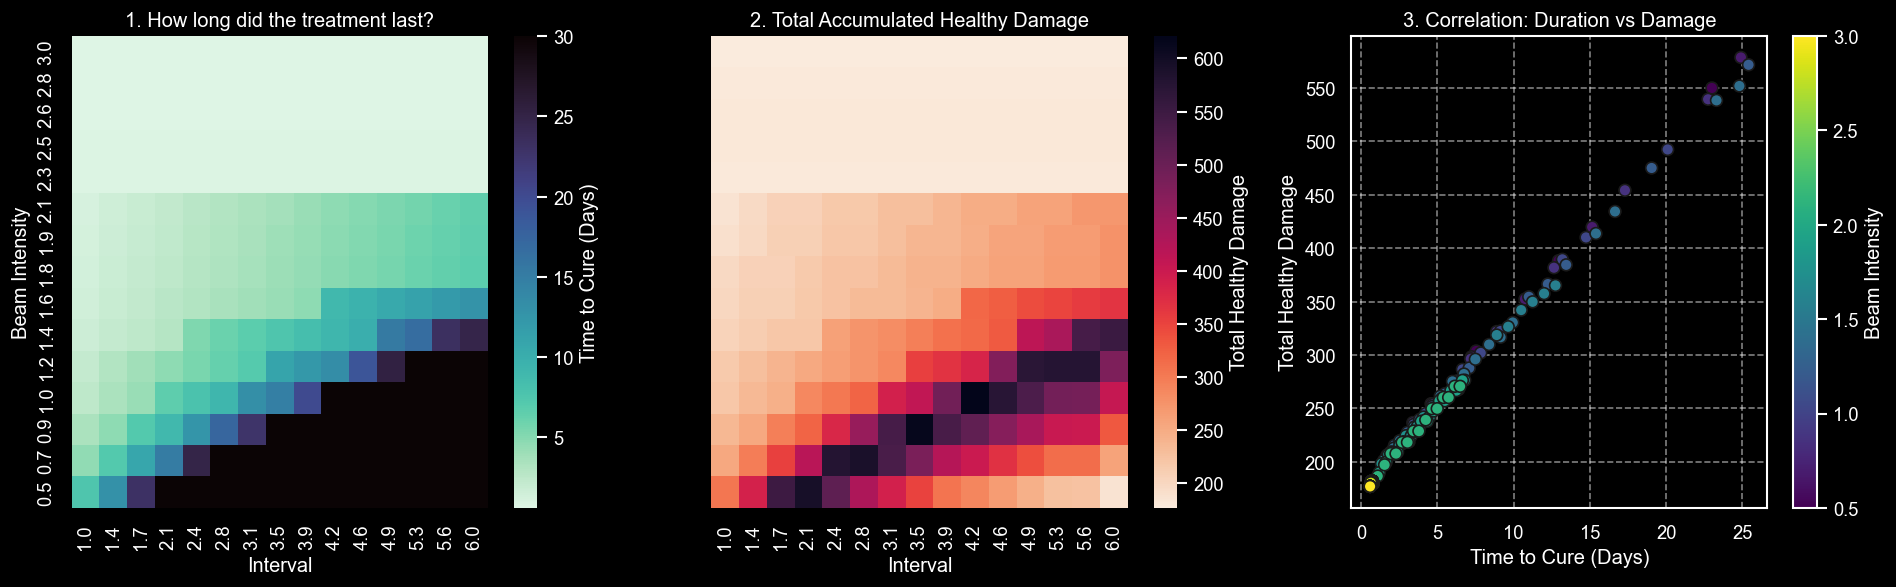

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="dark")
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 10, 'figure.dpi': 120})

class DiagnosticSolver:
    def __init__(self, L=10, N=40, T=30, dt=0.05):
        self.L = L; self.N = N; self.dx = L/N; self.dt = dt
        self.max_steps = int(T / dt)
        self.dx2 = self.dx**2
        
        self.x = np.linspace(-L/2, L/2, N)
        self.y = np.linspace(-L/2, L/2, N)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        
        # Hypoxia & Initial Tumor
        r = np.sqrt(self.X**2 + self.Y**2)
        self.H = 0.2 + 0.8 * (1 / (1 + np.exp(-(r - 2.0)*3)))
        self.u0 = 0.95 * np.exp(-(r**2)/3.5)

    def solve(self, interval, intensity):
        u = self.u0.copy()
        spatial_R = np.ones_like(self.X) * intensity
        
        cumulative_damage = 0.0
        time_to_cure = self.max_steps * self.dt # Default to max time
        cured = False
        
        # Fixed params
        rho = 0.5
        beta = 10.0
        duration = 0.8
        
        for n in range(self.max_steps):
            t = n * self.dt
            
            # 1. Check Cure Status
            current_mass = np.sum(u) * self.dx2
            if current_mass < 0.05:
                time_to_cure = t
                cured = True
                break # Stop the simulation (and the damage accumulation)
            
            # 2. Radiation Logic
            cycle_t = t % interval
            rad_on = 1.0 if cycle_t < duration else 0.0
            
            # 3. Accumulate Healthy Damage
            if rad_on > 0:
                h_frac = np.maximum(0, 1.0 - u)
                step_dam = np.sum(h_frac * spatial_R) * self.dx2 * self.dt
                cumulative_damage += step_dam
            
            # 4. PDE Step
            # Simple 5-point stencil with padding
            u_pad = np.pad(u, 1, mode='constant')
            lap = (u_pad[:-2, 1:-1] + u_pad[2:, 1:-1] + u_pad[1:-1, :-2] + u_pad[1:-1, 2:] - 4*u) / self.dx2
            
            growth = rho * u * (1 - u)
            kill = - beta * spatial_R * rad_on * self.H * u
            
            u += (0.05 * lap + growth + kill) * self.dt
            u = np.clip(u, 0, 1)
            
        return time_to_cure, cumulative_damage, cured

# --- RUN DIAGNOSTIC SWEEP ---
solver = DiagnosticSolver()
N_pts = 15
intervals = np.linspace(1.0, 6.0, N_pts)
intensities = np.linspace(0.5, 3.0, N_pts)

res_time = np.zeros((N_pts, N_pts))
res_damage = np.zeros((N_pts, N_pts))

# Lists for Scatter Plot
scatter_time = []
scatter_damage = []
scatter_intensity = []

print("Running Diagnostic Sweep...")
for i, intens in enumerate(intensities):
    for j, inv in enumerate(intervals):
        t_cure, dam, cured = solver.solve(interval=inv, intensity=intens)
        
        res_time[i, j] = t_cure
        res_damage[i, j] = dam
        
        if cured:
            scatter_time.append(t_cure)
            scatter_damage.append(dam)
            scatter_intensity.append(intens)

# --- PLOTTING ---
fig = plt.figure(figsize=(16, 5))
gs = fig.add_gridspec(1, 3)

# Plot 1: Time to Cure (The Driver)
ax1 = fig.add_subplot(gs[0])
sns.heatmap(res_time, ax=ax1, xticklabels=np.round(intervals,1), yticklabels=np.round(intensities,1),
            cmap="mako_r", cbar_kws={'label': 'Time to Cure (Days)'})
ax1.set_title("1. How long did the treatment last?")
ax1.set_xlabel("Interval"); ax1.set_ylabel("Beam Intensity")
ax1.invert_yaxis()

# Plot 2: Cumulative Damage (The Result)
ax2 = fig.add_subplot(gs[1])
sns.heatmap(res_damage, ax=ax2, xticklabels=np.round(intervals,1), yticklabels=np.round(intensities,1),
            cmap="rocket_r", cbar_kws={'label': 'Total Healthy Damage'})
ax2.set_title("2. Total Accumulated Healthy Damage")
ax2.set_xlabel("Interval"); ax2.set_yticks([])
ax2.invert_yaxis()

# Plot 3: Scatter Correlation
ax3 = fig.add_subplot(gs[2])
sc = ax3.scatter(scatter_time, scatter_damage, c=scatter_intensity, cmap='viridis', s=50, edgecolors='k')
plt.colorbar(sc, ax=ax3, label='Beam Intensity')
ax3.set_title("3. Correlation: Duration vs Damage")
ax3.set_xlabel("Time to Cure (Days)")
ax3.set_ylabel("Total Healthy Damage")
ax3.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("figures/paradox_explained.png")
plt.show()

Simulating Low Sensitivity (Resistant)...
Simulating Med Sensitivity (Response)...
Simulating High Sensitivity (Cure)...


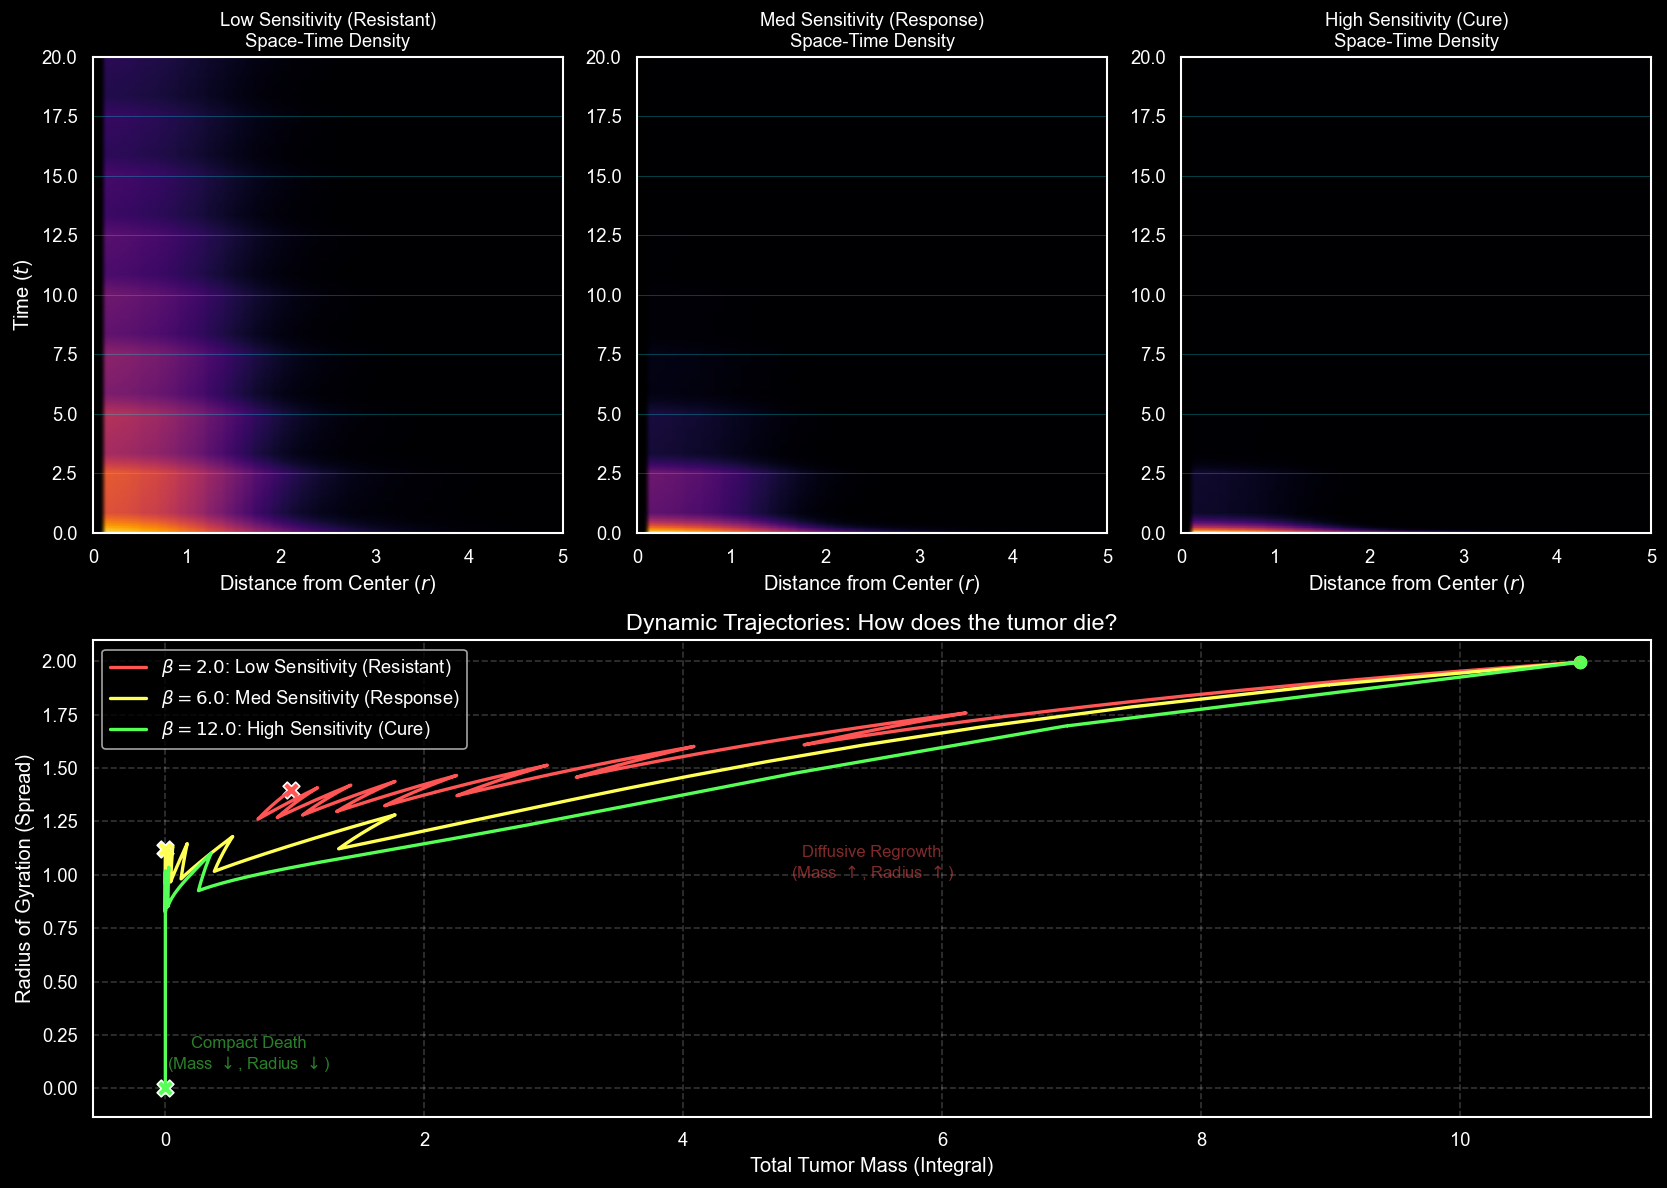

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binned_statistic

# Set style
plt.style.use('dark_background') # Moving to dark mode for high contrast
plt.rcParams.update({'font.size': 10, 'figure.dpi': 120})

class AdvancedAnalyzer:
    def __init__(self, L=10, N=60, T=20, dt=0.05):
        self.L = L; self.N = N; self.dx = L/N; self.dt = dt
        self.steps = int(T / dt)
        
        self.x = np.linspace(-L/2, L/2, N)
        self.y = np.linspace(-L/2, L/2, N)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        self.R_dist = np.sqrt(self.X**2 + self.Y**2)
        
        # Hypoxia (Central Core)
        self.H = 0.2 + 0.8 * (1 / (1 + np.exp(-(self.R_dist - 2.0)*3)))
        
        # Initial: Large Gaussian
        self.u0 = 0.9 * np.exp(-(self.R_dist**2)/4.0)

    def get_metrics(self, u):
        """Calculates Mass and Radius of Gyration"""
        mass = np.sum(u) * (self.dx**2)
        if mass < 1e-4: return 0, 0
        
        # Radius of Gyration (measure of spread)
        # sum(u * r^2) / sum(u)
        r_sq_weighted = np.sum(u * (self.R_dist**2)) * (self.dx**2)
        rog = np.sqrt(r_sq_weighted / mass)
        return mass, rog

    def radial_profile(self, u, bins=50):
        """Reduces 2D grid to 1D radial profile"""
        # We average u within concentric rings
        bin_means, bin_edges, _ = binned_statistic(
            self.R_dist.flatten(), u.flatten(), 
            statistic='mean', bins=bins, range=(0, self.L/2)
        )
        return bin_means

    def run_scenario(self, beta, label):
        u = self.u0.copy()
        
        # Storage for Hovmoller
        radial_history = [] 
        # Storage for Phase Space
        traj_mass = []
        traj_rad = []
        
        # Constants
        rho = 0.2
        dose_interval = 2.5
        dose_duration = 0.8
        intensity = 1.2
        spatial_R = np.ones_like(self.X) * intensity
        
        for n in range(self.steps):
            t = n * self.dt
            
            # Record Metrics
            m, r = self.get_metrics(u)
            traj_mass.append(m)
            traj_rad.append(r)
            
            # Record Radial Profile
            if n % 2 == 0: # Downsample slightly
                rad_prof = self.radial_profile(u)
                radial_history.append(rad_prof)
            
            # --- PDE Step ---
            cycle_t = t % dose_interval
            rad_on = 1.0 if cycle_t < dose_duration else 0.0
            
            # Laplacian
            u_pad = np.pad(u, 1, mode='constant')
            lap = (u_pad[:-2, 1:-1] + u_pad[2:, 1:-1] + u_pad[1:-1, :-2] + u_pad[1:-1, 2:] - 4*u) / (self.dx**2)
            
            growth = rho * u * (1 - u)
            kill = - beta * spatial_R * rad_on * self.H * u
            
            u += (0.05 * lap + growth + kill) * self.dt
            u = np.clip(u, 0, 1)
            
        return np.array(radial_history), traj_mass, traj_rad

# --- RUN EXPERIMENTS ---
analyzer = AdvancedAnalyzer()
scenarios = [
    (2.0, "Low Sensitivity (Resistant)"),
    (6.0, "Med Sensitivity (Response)"),
    (12.0, "High Sensitivity (Cure)")
]

results = []
for beta, name in scenarios:
    print(f"Simulating {name}...")
    hov, masses, rads = analyzer.run_scenario(beta, name)
    results.append((name, hov, masses, rads))

# --- PLOTTING ---

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 3) # 2 Rows, 3 Cols

# ROW 1: HOVMOLLER DIAGRAMS (Space-Time)
# We calculate the extent for imshow
r_max = analyzer.L / 2
t_max = analyzer.steps * analyzer.dt

for i, (name, hov, _, _) in enumerate(results):
    ax = fig.add_subplot(gs[0, i])
    # Transpose so Time is Y, Radius is X
    im = ax.imshow(hov, aspect='auto', origin='lower', cmap='inferno', 
                   extent=[0, r_max, 0, t_max], vmin=0, vmax=1)
    
    ax.set_title(f"{name}\nSpace-Time Density", color='white', fontsize=11)
    ax.set_xlabel("Distance from Center ($r$)")
    if i == 0: ax.set_ylabel("Time ($t$)")
    
    # Add Dose markers on Y-axis
    for t_dose in np.arange(0, t_max, 2.5):
        ax.axhline(t_dose, color='cyan', alpha=0.3, linewidth=0.5)

# ROW 2: PHASE SPACE TRAJECTORIES
ax_phase = fig.add_subplot(gs[1, :]) # Spans all columns

colors = ['#FF5555', '#FFFF55', '#55FF55'] # Red, Yellow, Green

for i, (name, _, masses, rads) in enumerate(results):
    # Plot line
    ax_phase.plot(masses, rads, color=colors[i], linewidth=2, label=f"$\\beta={scenarios[i][0]}$: {name}")
    
    # Add arrows to show direction of time
    # We take indices at 0, 20%, 40%... of the simulation
    indices = np.linspace(0, len(masses)-1, 6, dtype=int)
    for idx in indices[:-1]:
        ax_phase.arrow(masses[idx], rads[idx], 
                       masses[idx+1]-masses[idx], rads[idx+1]-rads[idx], 
                       shape='full', lw=0, length_includes_head=True, head_width=0.02, color=colors[i])
    
    # Start/End markers
    ax_phase.scatter(masses[0], rads[0], marker='o', color=colors[i], s=50) # Start
    ax_phase.scatter(masses[-1], rads[-1], marker='X', color=colors[i], s=100, edgecolors='white') # End

ax_phase.set_title("Dynamic Trajectories: How does the tumor die?", fontsize=14)
ax_phase.set_xlabel("Total Tumor Mass (Integral)", fontsize=12)
ax_phase.set_ylabel("Radius of Gyration (Spread)", fontsize=12)
ax_phase.grid(True, linestyle='--', alpha=0.2)
ax_phase.legend()

# Add logic annotation
ax_phase.text(0.5, 0.5, "Diffusive Regrowth\n(Mass $\\uparrow$, Radius $\\uparrow$)", 
              transform=ax_phase.transAxes, color='#FF5555', alpha=0.5, ha='center')
ax_phase.text(0.1, 0.1, "Compact Death\n(Mass $\\downarrow$, Radius $\\downarrow$)", 
              transform=ax_phase.transAxes, color='#55FF55', alpha=0.5, ha='center')

plt.tight_layout()
plt.savefig("figures/advanced_sensitivity.png")
plt.show()